In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available() #True
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") #if문이 True이므로 cpu로 이동
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


In [0]:
torch.cuda.is_available?
torch.cuda.is_available?
torch.device?

In [3]:
# Fashion MNIST 학습 데이터셋
trainset = datasets.FashionMNIST( #dataset
    root      = './.data/', 
    train     = True, #If True, creates dataset from ``training.pt``, otherwise from ''test.pt''
    download  = True, #If true, downloads the dataset from the internet and  puts it in root directory.
    transform = transforms.ToTensor() #Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
)

train_loader = torch.utils.data.DataLoader( #data load
    dataset     = trainset, #train_loader의 dataset을 trainset으로 설정
    batch_size  = BATCH_SIZE, #64
    shuffle     = True,
    num_workers = 2 #default는 0으로, 0일 경우 main process만 data load에 관여. 2일 경우 2개의 subprocess가 관여.
                    #많을 수록 좋은 것은 아님. 그만큼 다른 연산에 delay가 생김. 그래서 적절한 개수를 선택하는 것이 중요.
)

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
datasets.FashionMNIST?
transforms.ToTensor?
torch.utils.data.DataLoader?

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x): #encoder -> decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
nn.Sequential?

In [0]:
autoencoder = Autoencoder().to(DEVICE) #cpu
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:
torch.optim.Adam?

In [0]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise #이미지 사이즈 크기 만큼의 랜덤 픽셀값을 원본 이미지에 더해서 노이즈 이미지 생성
    return noisy_img

In [0]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0 #새로 추가
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x)  # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) #Creates a criterion that measures the mean squared error between each element in the input.
        optimizer.zero_grad() #Clears the gradients of all optimized
        loss.backward()
        optimizer.step() #Performs a single optimization step.
        
        avg_loss += loss.item() #새로 추가
    return avg_loss / len(train_loader)

In [0]:
criterion?
optimizer.zero_grad?

In [8]:
for epoch in range(1, EPOCH+1): #(1,11)
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))
    # 이번 예제에선 학습시 시각화를 건너 뜁니다

[Epoch 1] loss:0.07368496244252999
[Epoch 2] loss:0.06512489389064216
[Epoch 3] loss:0.06391973791918013
[Epoch 4] loss:0.0633393517697353
[Epoch 5] loss:0.0628954396406407
[Epoch 6] loss:0.0625642219435241
[Epoch 7] loss:0.06231553740958288
[Epoch 8] loss:0.06254953525658609
[Epoch 9] loss:0.06237216136936567
[Epoch 10] loss:0.062127571139953285


In [0]:
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옵니다.
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False, #If True, creates dataset from ``training.pt``, otherwise from ''test.pt''
    download  = True, #If true, downloads the dataset from the internet and  puts it in root directory.
    transform = transforms.ToTensor() #Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
)

# 테스트셋에서 이미지 한장을 가져옵니다.
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킵니다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) #decoder의 return값이 recovered_x에 저장

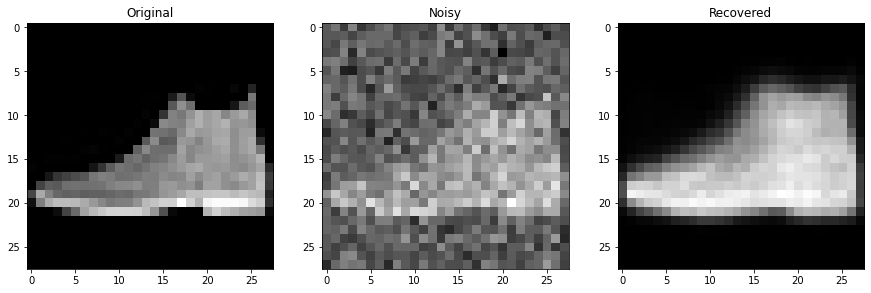

In [11]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()